<a href="https://colab.research.google.com/github/solobala/DLL30/blob/main/DLL30_DZ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание по теме «Основы нейронных сетей» (самостоятельное)

Цель задания:
научиться обучать простейшую нейросетевую модель, практически эквивалентную алгоритму линейной регрессии, с помощью метода градиентного спуска в pytorch

**Задание **
Реализуйте обучение нейронной сети из одного нейрона для задачи предсказания стоимости квартир boston house prices или california housing prices с использованием pytorch.

Инструкция к выполнению задания

1. Загрузите и подготовьте данные
2. Разделите данные на test и train
3. Создать модель (объект) класса. Для создания объекта можно использовать  класс Sequential
4. Обучите модель на train данных
5. Проверьте качество модели на тестовых данных


#0. Импорт библиотек и пользовательские функции

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 14.5 MB/s eta 0:00:00


In [2]:
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, chi2, mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import autograd

In [5]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

In [6]:
def make_corr(data, X, y, discrete_features):
  """
   Возвращает к-ты корреляции в формате Series
  """
  corr = data.corr()
  corr_scores = pd.Series(corr, name="corr Scores", index=X.columns)
  corr_scores = corr_scores.sort_values(ascending=False)
  return corr_scores

In [7]:
def make_mi_scores(X, y, discrete_features):
  """
    Взаимная информация (МИ) между двумя случайными величинами представляет собой
    неотрицательную величину, которая измеряет зависимость между переменными.
    Равна нулю тогда и только тогда, когда две случайные величины независимы,
    а более высокие значения означают более высокую зависимость.

    Функция основана на непараметрических методах оценки энтропии
    по k-ближайшим соседним расстояниям.
    Можно использовать для выбора одномерных признаков (sci-kit learn)
  """
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

In [8]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [9]:
def get_learn(X,y,random_seed, model):
  """
  Служебная функция. выполняет:
    - разделение на Train и test
    - обучение модели
    - расчет метрикb качества score
    возвращает название метода удаления выбросов,
    model - модель классификатора,
  """

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
  lr = model
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  a = lr.score(X_test, y_test)
  r2score = np.sqrt(mean_squared_error(y_test, y_pred))
  return a, r2score

# 1. Загрузка данных

In [11]:
column_names = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat', 'price']
data = pd.read_csv('/content/housing.csv', header=None, delimiter=r"\s+", names=column_names)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    float64
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  price    506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [13]:
X = data.drop(columns=['price'])

In [14]:
X.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


In [15]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X.values)
scaled_X = pd.DataFrame(scaled_features, columns=X.columns)

In [16]:
scaled_X.shape

(506, 13)

In [17]:
y = data['price']

#2. Подготовка данных

Базовая модель

In [19]:
a_base, rmse_base = get_learn(scaled_X, y, random_seed=42, model=LinearRegression())
a_base, rmse_base

(0.668759493535632, 4.928602182665337)

In [20]:
df_results= pd.DataFrame(columns = ['method', 'features', 'r2score', 'rmse'])
df_results.loc[len(df_results.index)] = ['baseline', X.columns.tolist(),  a_base, rmse_base]

## 2.1. Отбор значимых признаков

### 2.1.1. С помощью SHAP

In [21]:
shap.initjs()
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns.tolist()[i], "=", model.coef_[i].round(5))
print(f'Самые большие по модулю к-ты {X.columns.tolist()[model.coef_.tolist().index(model.coef_.max())]} и {X.columns.tolist()[model.coef_.tolist().index(model.coef_.min())]}')


Model coefficients:

crim = -0.97149
zn = 0.70156
indus = 0.27675
chas = 0.70653
nox = -1.99143
rm = 3.11572
age = -0.17706
dis = -3.04577
rad = 2.28278
tax = -1.7926
ptratio = -1.97995
b = 1.1265
lstat = -3.62815
Самые большие по модулю к-ты rm и lstat


PermutationExplainer explainer: 507it [00:22, 14.62it/s]


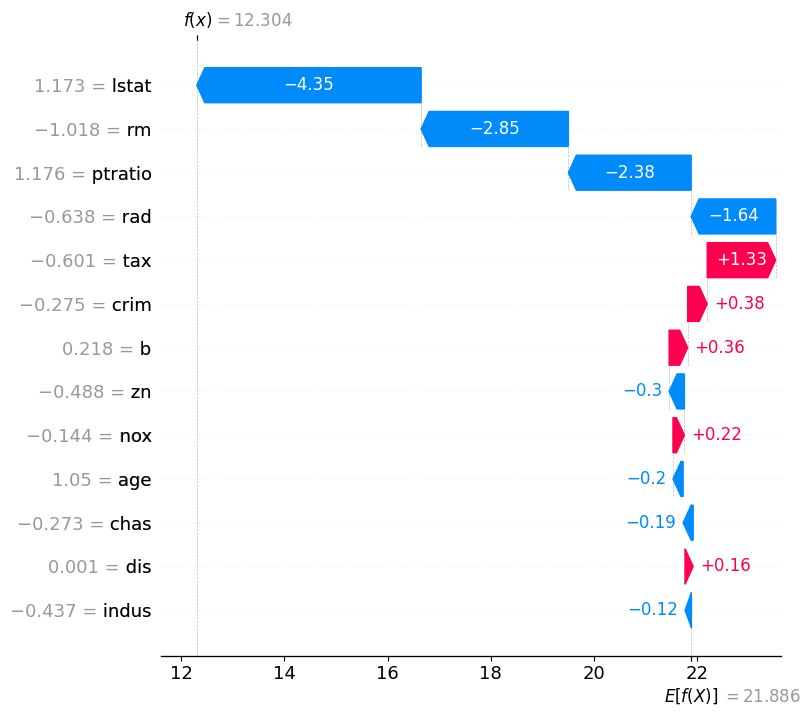

In [22]:
explainer = shap.Explainer(model.predict, scaled_X)
shap_values = explainer(scaled_X)
shap.plots.waterfall(shap_values[20], max_display=20 )

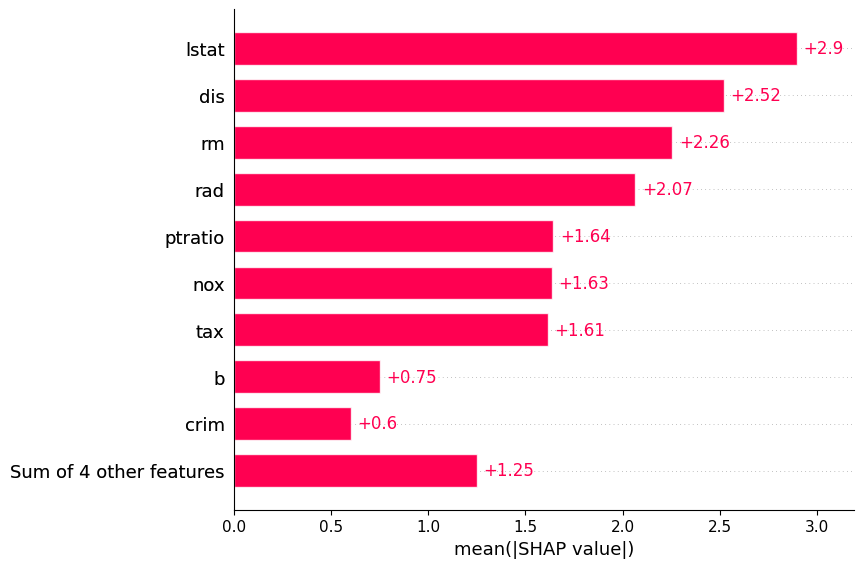

In [23]:
shap.plots.bar(shap_values)

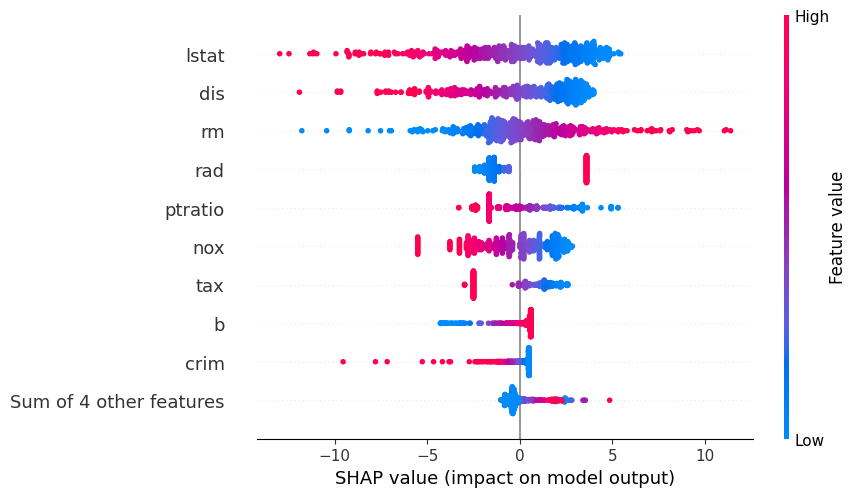

In [24]:
shap.plots.beeswarm(shap_values )

Оставляем lstat, dis, rm, rad, ptratio, nox, tax

In [26]:
features = ['lstat', 'dis', 'rm', 'rad','ptratio','nox', 'tax']
method = 'SHAP'
a, rmse= get_learn(scaled_X[features], y, random_seed=42, model=LinearRegression())
df_results.loc[len(df_results.index)] = [method, scaled_X[features].columns.tolist(),  a, rmse]

In [27]:
df_results.sort_values(by='r2score', ascending=False)

,method,features,r2score,rmse
1,SHAP,"[lstat, dis, rm, rad, ptratio, nox, tax]",0.672654,4.899540
0,baseline,"[crim, zn, indus, chas, nox, rm, age, dis, rad...",0.668759,4.928602


### 2.1.2. Использование статистических методов для отбора признаков

#### 2.1.2.1. Выбор признаков на основе матрицы корреляции (Тепловая карта)

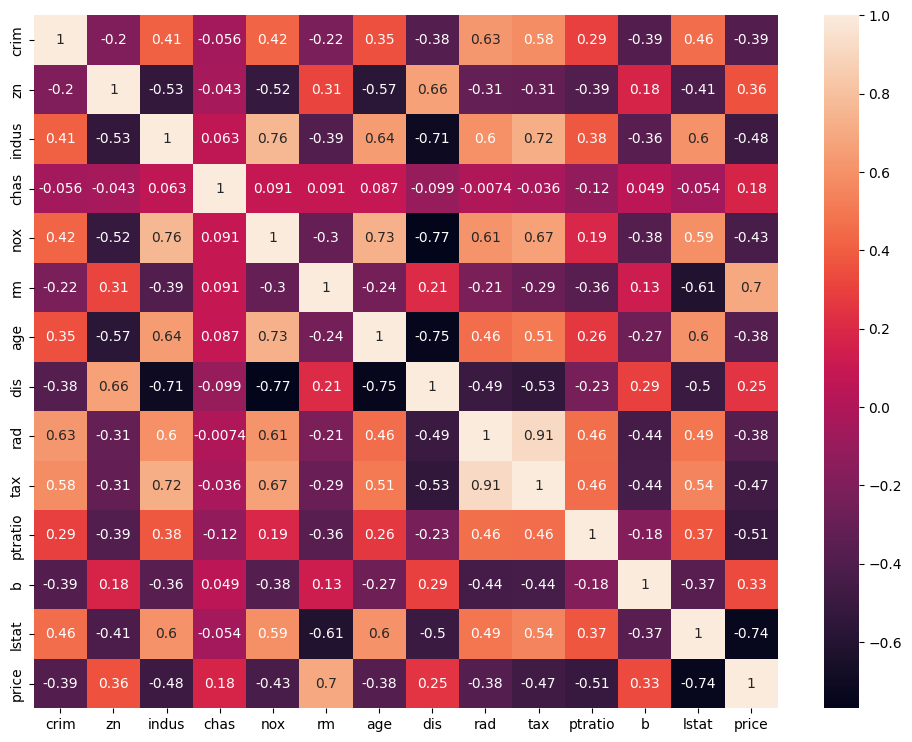

In [28]:
corr = data.corr()
plt.figure(figsize=(12,9))
sns.heatmap(corr,annot=True)
plt.show()

lstat, rn, ptratio, indus, tax, rad, crim, age

In [29]:
from scipy.stats import pearsonr # В этой библиотеке не только к-т корреляции считается, но и p_value для него
a_base=0.6
thresholds = [0.4,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.9] # здесь указан порог к-та корреляции ( т.е. построена матрица, то данные взяты оттуда, а то можо было и перебором)

for thr in thresholds:
  corr_columns=[]
  method = f'corr {thr}'
  for b in scaled_X.columns.to_list():

    if (abs(pearsonr(scaled_X[b], y)[0])>=thr) & (abs(pearsonr(scaled_X[b], y)[1])<=0.05) & (b !='target'):
      corr_columns.append(b)

  features = list(set(corr_columns))

  if features !=[]:
    a, rmse = get_learn(scaled_X[features], y, random_seed=42, model=LinearRegression())

    if a>=a_base:
      a_base = a
      a_opt = a
      rmse_opt = rmse
      features_opt = features
      method_opt = method



In [30]:
features_opt

['indus', 'rm', 'tax', 'nox', 'ptratio', 'lstat']

In [31]:
a_opt, rmse_opt

(0.6209548378098446, 5.272268556515525)

In [34]:
df_results.loc[len(df_results.index)] = [method_opt, features_opt,  a_opt, rmse_opt]

#### 2.1.2.2 Выбор признаков на основе Mutual Information

In [36]:
mi_scores = make_mi_scores(scaled_X, y, discrete_features='auto')
mi_scores

lstat      0.664254
rm         0.526300
nox        0.473429
indus      0.468173
ptratio    0.457687
tax        0.371660
crim       0.339961
age        0.310081
dis        0.297240
rad        0.229572
zn         0.170358
b          0.153008
chas       0.012575
Name: MI Scores, dtype: float64

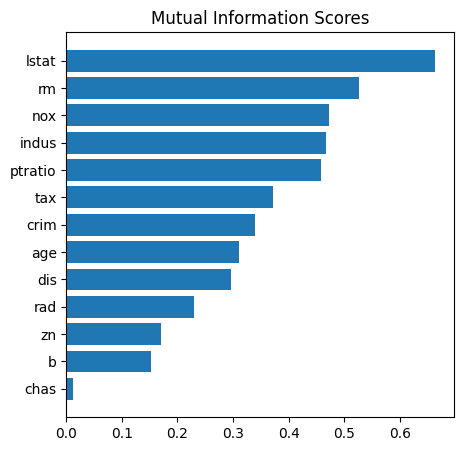

In [37]:
plt.figure(dpi=100, figsize=(5, 5))
plot_mi_scores(mi_scores)

In [38]:
features = mi_scores[mi_scores>0.2].index.tolist()
features = features[:-1]
features

['lstat', 'rm', 'nox', 'indus', 'ptratio', 'tax', 'crim', 'age', 'dis']

In [39]:
count = len(mi_scores[mi_scores>0.01])
features = mi_scores[mi_scores>0.01].index.tolist()
a_base=0.65
for i in range(count,1,-1):
  method = f'MI {i}'
  a, rmse = get_learn(scaled_X[features], y, random_seed=42, model=LinearRegression())
  # print(a, features)
  if a>=a_base:
    a_base = a
    a_opt = a
    rmse_opt=rmse
    features_opt = features
    method_opt = method
  features = features[:-1] # убираем по одному признаку до тех пор, пока метрика не начнет падать


In [40]:
a_opt, rmse_opt

(0.6870176307083735, 4.790843475071615)

In [41]:
features_opt

['lstat',
 'rm',
 'nox',
 'indus',
 'ptratio',
 'tax',
 'crim',
 'age',
 'dis',
 'rad',
 'zn']

In [42]:
df_results.loc[len(df_results.index)] = [method_opt, features_opt,  a_opt, rmse_opt]

### 2.1.3  Oтбор признаков на основе дисперсионного анализа

#### 2.1.3.1. 5 лучших признаков с помощью скоринговой функции для классификации f_regression (SelectKBest(f_regression, k=5)).

In [43]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
selector = SelectKBest(f_regression, k=5)
X_new = selector.fit_transform(scaled_X, y)
method = 'SelectKBest k=5'
cols_idxs = selector.get_support(indices=True)
features = data.iloc[:,cols_idxs].columns.tolist()

In [44]:
a, rmse =get_learn(X_new,y, random_seed=42, model=LinearRegression())

In [45]:
df_results.loc[len(df_results.index)] = [method, features,  a, rmse]

####2.1.3.2. Отсечение низковариативных признаков (VarianceThreshold)

In [47]:
# Меняем Threshhold в диапазоне и ищем порог, при котором модель показывает лучшую r2score
thresholds = np.arange(0.25, 1.7, 0.05)
a_base=0.68
for thr in thresholds:

  method = f'VarianceThreshold_{thr:.2f}'
  selector = VarianceThreshold(thr)
  X_var = selector.fit_transform(X)
  a, rmse = get_learn(X_var,y, random_seed=42, model=LinearRegression())


  if a >= a_base:
    a_base=a
    method_opt = method
    rmse_opt=rmse
    features_opt = selector.get_feature_names_out().tolist()
    a_opt = a


In [48]:
a_opt, rmse_opt

(0.6870176307083735, 4.790843475071615)

In [49]:
features_opt

['lstat',
 'rm',
 'nox',
 'indus',
 'ptratio',
 'tax',
 'crim',
 'age',
 'dis',
 'rad',
 'zn']

In [50]:
df_results.loc[len(df_results.index)] = [method_opt, features_opt,  a_opt, rmse_opt]

#### 2.1.3.3. Пример с использованием PCA

In [51]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

In [52]:
a_base=0.68
for i in range(1,14):

  pca = PCA(n_components=i, random_state=42)
  pca.fit(X_train, y_train)
  X_pca = pca.transform(scaled_X)
  a, rmse = get_learn(X_pca,y, random_seed=42, model=LinearRegression())
  if a > a_base:
    a_base = a
    a_opt=a
    rmse_opt=rmse
    print(pca.explained_variance_ratio_)
    method = f'PCA n_components={i}'
    features=[f'трансформированные в {i} признаки']


In [53]:
a_opt, rmse_opt

(0.6870176307083735, 4.790843475071615)

In [54]:
df_results.loc[len(df_results.index)] = [method, features,  a_opt, rmse_opt]

### 2.1.4. Перебор признаков

In [48]:
X = data.drop(columns=['price'])

In [55]:
from sklearn.feature_selection import SequentialFeatureSelector
feature_names = scaled_X.columns
model=LinearRegression()
sfs = SequentialFeatureSelector(model, n_features_to_select=9, direction='backward')
sfs.fit(scaled_X, y)
features = feature_names[sfs.get_support()].tolist()
print(
    "Признаки, отобранные SequentialFeatureSelector: "
    f"{features}"
)

Признаки, отобранные SequentialFeatureSelector: ['crim', 'zn', 'nox', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']


In [56]:
a, rmse = get_learn(scaled_X[features] ,y, random_seed=42, model=LinearRegression())
method='LR_SequentialFeatureSelector_backward'
a, rmse

(0.6910612678407735, 4.759794742842365)

In [57]:
df_results.loc[len(df_results.index)] = [method, features,  a, rmse]

In [58]:
df_results.sort_values(by='r2score', ascending=False)

,method,features,r2score,rmse
7,LR_SequentialFeatureSelector_backward,"[crim, zn, nox, dis, rad, tax, ptratio, b, lstat]",0.691061,4.759795
3,MI 11,"[lstat, rm, nox, indus, ptratio, tax, crim, ag...",0.687018,4.790843
5,MI 11,"[lstat, rm, nox, indus, ptratio, tax, crim, ag...",0.687018,4.790843
6,VarianceThreshold_1.65,"[indus, rm, tax, ptratio, lstat]",0.687018,4.790843
1,SHAP,"[lstat, dis, rm, rad, ptratio, nox, tax]",0.672654,4.899540
0,baseline,"[crim, zn, indus, chas, nox, rm, age, dis, rad...",0.668759,4.928602
2,corr 0.4,"[indus, rm, tax, nox, ptratio, lstat]",0.620955,5.272269
4,SelectKBest k=5,"[indus, rm, tax, ptratio, lstat]",0.619668,5.281208


Лучше всего модель линейной регрессии получается при использовании признаков crim, zn, nox, dis, rad, tax, ptratio, b, lstat. ПРи построении линейной регрессии с использованием pytorch проверим 2 варианта - построение мрдели на всех признаках и на выбранных

## 2.2. Загрузка данных в тензор

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [60]:
# Сколько признаков? (к-во нейронов на входе)
n = data.drop(columns=['price']).shape[1]
n

13

In [61]:
# разбиваем исходный датасет на train и test
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [62]:
class MyDataset(torch.utils.data.Dataset):
    """
    Создаем класс, наследующийся от Dataset, и переопределяем в нем методы __init__, __len__ и __getitem__.
    В методе __init__ необходимо загрузить данные из pandas dataframe и сохранить их в атрибуты класса.
    В методе __len__ нужно вернуть количество элементов в датасете.
    В методе __getitem__ нужно вернуть один элемент датасета по индексу.
    """
    def __init__(self, df):
        self.X = df.drop(['price'], axis=1).values
        self.y = df['price'].values

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

In [63]:
# Загружаем данные из датафрейиов train и test в объекты типа Dataset
train_dataset = MyDataset(train)
test_dataset = MyDataset(test)

In [64]:
train_dataset[0]

(tensor([1.5023e+01, 0.0000e+00, 1.8100e+01, 0.0000e+00, 6.1400e-01, 5.3040e+00,
         9.7300e+01, 2.1007e+00, 2.4000e+01, 6.6600e+02, 2.0200e+01, 3.4948e+02,
         2.4910e+01], dtype=torch.float64),
 tensor(12., dtype=torch.float64))

In [65]:
def get_scaled_dataset(d):
  """Выполняем масштабирование элементов датасета d"""
  scaler = StandardScaler()
  features = [x[0].numpy() for x in d]
  labels = [x[1].numpy() for x in d]
  scaled_features = scaler.fit_transform(features)
  scaled_dataset = [(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)) for x, y in zip(scaled_features, labels)]
  return scaled_dataset

In [66]:
scaled_train_dataset = get_scaled_dataset(train_dataset)
scaled_train_dataset[0:8]

[(tensor([ 1.2877, -0.5003,  1.0332, -0.2781,  0.4893, -1.4281,  1.0280, -0.8022,
           1.7069,  1.5784,  0.8453, -0.0743,  1.7535]),
  tensor(12.)),
 (tensor([-0.3364, -0.5003, -0.4132, -0.2781, -0.1572, -0.6801, -0.4312,  0.3243,
          -0.6244, -0.5846,  1.2047,  0.4302, -0.5615]),
  tensor(19.9000)),
 (tensor([-0.4033,  1.0133, -0.7152, -0.2781, -1.0087, -0.4021, -1.6186,  1.3307,
          -0.9740, -0.6027, -0.6372,  0.0653, -0.6516]),
  tensor(19.4000)),
 (tensor([ 0.3882, -0.5003,  1.0332, -0.2781,  0.4893, -0.3005,  0.5917, -0.8392,
           1.7069,  1.5784,  0.8453, -3.8682,  1.5254]),
  tensor(13.4000)),
 (tensor([-0.3253, -0.5003, -0.4132, -0.2781, -0.1572, -0.8311,  0.0337, -0.0055,
          -0.6244, -0.5846,  1.2047,  0.3791, -0.1658]),
  tensor(18.2000)),
 (tensor([-0.3855, -0.5003, -0.5235, -0.2781, -0.5400,  0.1625, -1.9262,  0.7553,
          -0.5078, -0.7052,  0.5758,  0.4090, -1.0388]),
  tensor(24.6000)),
 (tensor([-0.4027, -0.5003, -0.8416, -0.2781, -0.3

In [67]:
scaled_test_dataset = get_scaled_dataset(test_dataset)
scaled_test_dataset[0]

(tensor([-0.4768, -0.4402, -1.1492, -0.2500, -0.3480,  0.3863,  0.5375, -0.5481,
         -0.5828, -0.7299, -1.3389,  0.4131, -0.6087]),
 tensor(23.6000))

In [68]:
# Определяем загрузчики
train_dataloader = DataLoader(scaled_train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(scaled_test_dataset, batch_size=8, shuffle=True)

In [69]:
# проверяем
for X, y in train_dataloader:
    print(X, y)
    break

tensor([[-0.3967, -0.5003,  2.1297, -0.2781,  0.2085, -0.5009,  0.8706, -0.8087,
         -0.8575, -1.3017,  0.3512,  0.2385,  0.7706],
        [-0.4002,  1.2295, -1.4137, -0.2781, -1.0844,  0.2457, -0.8640,  2.3414,
         -0.9740, -0.4159,  0.6207,  0.4442, -0.9121],
        [-0.4008, -0.5003, -1.2380, -0.2781, -0.5826,  2.1383, -0.5349, -0.2861,
         -0.7409, -1.2715, -0.2329,  0.3975, -1.1275],
        [ 0.1797, -0.5003,  1.0332,  3.5960,  1.8162, -0.2666,  0.5309, -0.5100,
          1.7069,  1.5784,  0.8453,  0.4281, -0.1376],
        [-0.4049,  2.9593, -1.3397, -0.2781, -1.4587, -0.1212, -1.3253,  2.4810,
         -0.9740, -0.9823, -0.0532, -0.1605,  0.0666],
        [-0.3734,  0.3646, -0.5845, -0.2781, -0.7867, -0.6490, -0.9462,  0.2917,
         -0.7409, -1.0908,  0.1265,  0.3540,  0.0764],
        [-0.4024,  0.7106,  0.5889, -0.2781, -0.7867,  0.1780, -0.5349, -0.0668,
         -0.6244, -0.8076, -0.0532,  0.4235, -0.6051],
        [-0.3933, -0.5003, -0.1416, -0.2781, -0.

In [75]:
# Create model and define RMSE loss.
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(13, 1)  # Define the weight matrix. Size: Number of features x Number of targets

    def forward(self, x):
        x = self.linear(x)
        return x

In [81]:
def R2score(y_true, y_pred):
    """
    Вычисляет коэффициент детерминации (R2 score) между y_true и y_pred.
    """
    ss_res = torch.sum(torch.square(y_true - y_pred))
    ss_tot = torch.sum(torch.square(y_true - torch.mean(y_true)))
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [74]:
def RMSELoss(yhat,y):
    return torch.sqrt(F.mse_loss(yhat, y))

In [83]:
def fit(num_epochs, model, loss_fn, r2score_fn, optimizer, train_dataloader, val_loader):
    for epoch in range(num_epochs):
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Get predictions.
            preds = model(inputs)
            # Get loss.
            loss = loss_fn(preds, targets)
            # Compute gradients.
            loss.backward()
            # Update model parameters i.e. backpropagation.
            optimizer.step()
            # Reset gradients to zero before the next epoch.
            optimizer.zero_grad()

        if (epoch + 1) % 50 == 0:
            # Get validation loss as well.
            for val_input, val_targets in val_loader:
                val_input, val_targets = val_input.to(device), val_targets.to(device)
                out = model(val_input)
                val_loss = RMSELoss(out, val_targets)
                r2score = R2score(out, val_targets)
            print("Epoch [{}/{}], Training loss: {:.4f}, Validation Loss: {:.4f} r2score:{:.4f}".format(epoch + 1, num_epochs, loss.item(), val_loss, r2score)) # Report loss value after each epoch.

In [87]:
# Define model training metadata.
num_epochs = 3000
model = LinearRegression()
model.to(device)
loss_fn = RMSELoss
r2score_fn = R2score
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

In [ ]:
# # Making sure shapes are correct and defining dataloader.
# input_np_array = np.array(dataset[:,1:-1].tolist(), dtype='float32')
# inputs = torch.from_numpy(input_np_array)
# # inputs = torch.from_numpy(np.array(dataset.iloc[:,1:-1].values, dtype='float32'))
# print(inputs.shape)
# targets_np_array = np.array(dataset[:,-1].tolist(), dtype='float32')
# targets_np_array_rs = np.reshape(targets_np_array, (targets_np_array.shape[0],1))
# targets = torch.from_numpy(targets_np_array_rs)
# print(targets.shape)
# # targets = torch.from_numpy(np.array(dataset.iloc[:,-1].values, dtype='float32'))


# train_tensor_dataset = TensorDataset(inputs, targets)
# val_size, train_size = int(0.1 * len(train_tensor_dataset)),  len(train_tensor_dataset) - int(0.1 * len(train_tensor_dataset))
# batch_size = 50
# train_data, val_data = random_split(train_tensor_dataset, [train_size, val_size])
# train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
# val_dataloader = DataLoader(val_data, batch_size)

In [88]:
fit(num_epochs, model, loss_fn, r2score_fn, optimizer, train_dataloader, test_dataloader)

Epoch [50/3000], Training loss: 19.1070, Validation Loss: 19.7919 r2score:-19964.3125
Epoch [100/3000], Training loss: 26.0753, Validation Loss: 15.8697 r2score:-21519.2148
Epoch [150/3000], Training loss: 14.6713, Validation Loss: 12.5342 r2score:-29668.5605
Epoch [200/3000], Training loss: 22.7807, Validation Loss: 18.8155 r2score:-20425.3750
Epoch [250/3000], Training loss: 22.4971, Validation Loss: 6.1295 r2score:-3878.3987
Epoch [300/3000], Training loss: 12.8091, Validation Loss: 7.7946 r2score:-5880.1528
Epoch [350/3000], Training loss: 8.6282, Validation Loss: 16.1911 r2score:-7073.2930
Epoch [400/3000], Training loss: 3.4914, Validation Loss: 3.9903 r2score:-549.8641
Epoch [450/3000], Training loss: 6.2335, Validation Loss: 14.3269 r2score:-2643.5601
Epoch [500/3000], Training loss: 5.6817, Validation Loss: 4.6033 r2score:-340.9673
Epoch [550/3000], Training loss: 3.1188, Validation Loss: 11.8563 r2score:-3175.3318
Epoch [600/3000], Training loss: 0.7315, Validation Loss: 11.6